# **Lab 6: Convolutional Network Architectures - Brain Tumor MRI Images**

- Reece Iriye: 48255107
- Eileen Garcia: 48241821
- Trevor Dohm: 48376059

## **0: Imports**

In [4]:
# Import Statements

# MacOS Environment
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Data Manipulation
import numpy as np
import pandas as pd
import glob
import os

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Image Manipulation
from PIL import Image, ImageEnhance
import cv2

# Machine Learning
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, Reshape
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator

# Warnings
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

In [3]:
print('Tensorflow Version:', tf.__version__)
tf.config.list_physical_devices('GPU')

Tensorflow Version: 2.14.0


2023-11-26 19:59:09.998616: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 19:59:10.002456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 19:59:10.002508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## **1: Business & Data Understanding**

### **1.1: Dataset Overview**

The "Brain Tumor MRI Dataset" on <a href="https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset">Kaggle</a> provides a comprehensive collection of human brain MRI images aimed at supporting the accurate detection and classification of brain tumors. Consisting of 7,023 images from three distinct datasets - figshare, SARTAJ, and Br35H - this dataset separates MRI scans of brains into four categories: `glioma`, `meningioma`, `no tumor`, and `pituitary`. The dataset has seen several changes according to the description on Kaggle, with some `glioma` images from the SARTAJ dataset being replaced due to inaccuracies, highlighting ongoing modifications being made to the dataset for improved reliability and data quality. With images from the Br35H dataset constituting the `no tumor` class, users should be mindful that the images in this dataset come in varied sizes, meaning that pre-processing and re-sizing must be employed for us to achieve consistent analysis and improved model accuracy.

### **1.2: Purpose of Data Collection**

Brain tumors as a whole pose severe risks given the confined space of the skull, whether or not they are <a href="https://www.cedars-sinai.org/blog/diagnosed-with-benign-tumor.html">malignant or benign</a>. Growth of these tumors can potentially lead to brain damage and life-threatening situations. Timely detection and precise classification of these tumors are absolutely essential in guiding pre-emptive medical diagnosis before tumors signifcantly effect and harm a patient. With MRI's being a predominant imaging technique in this realm, there is a pressing need for advanced diagnostic models that can detect, classify by type, and pinpoint tumor locations effectively. This dataset, assembled from various sources and continuously refined, aims to provide a rich resource for researchers and data scientists to develop advanced machine learning models to aid in these critical diagnostic tasks.

### **1.3: Prediction Task & Stakeholder Interest**

This MRI dataset from Kaggle has been created with the specific intention to facilitate the development of models capable of detecting the presence of a brain tumor from MRI scans and classifying them by type. Medical practitioners and technicians can then use them as an advisory tool to make more precise diagnoses, leading to more targeted treatment options. Accurate labels are extremely important. It's crucial to acknowledge potential inaccuracies, such as those noted in the SARTAJ dataset, ensuring that machine learning models are trained on the most reliable data available.

### **1.4: Algorithm Performance Expectation for Medical Efficacy**

For a machine learning approach in the domain of medical diagnosis to be clinically valuable, the algorithm must excel in capturing intricate details, variations, and nuances from MRI images. Given the collection of data from multiple sources in this Kaggle dataset, a successful algorithm should be adaptable, handling diverse imaging techniques and varying image sizes efficiently. Specifically, it should excel in tasks like tumor detection and type classification, ideally performing better than current diagnostic thresholds in accuracy and reliability. Furthermore, the emphasis on pre-processing, such as resizing images for uniformity, underscores the need for meticulous data preparation to enhance the model's performance. Ultimately, an ideal algorithm would bolster the confidence of medical practitioners in their diagnostic decisions, ensuring timely and effective interventions for patients.

Additionally, the tumor labels should ideally not come from initial diagnoses made by medical practitioners. Instead, the tumor label should be derived a considerable time after the MRI scan to ensure that we capture the ground truth about the existence and type of tumor for a patient, instead of preliminary assessments or biases. Using preliminary data would capture medical biases and cause the trained model to capture the exact same biases as a result. This delayed-labeling approach ensures the training data for machine learning models is as close to the eventual outcome as possible, enhancing the model's predictive accuracy and establishing value that can support medical practitioners and doctors in labeling true diagnoses.

## **2: Data Preparation**

### **2.1: Data Preprocessing Steps**

#### **2.1.1: Dataset Directory Structure**

The Kaggle brain MRI dataset is structured in distinct training and testing folders. We are going to merge all of these together into one dataset then perform our own data splitting, but for now, until section **2.4.6**, we will check how the MRI scans appear for each individual class in both pre-packaged Kaggle directories separately.

#### **2.1.2: Image Dimensions Standardization**

All MRI images are likely varying in size, with some images being much larger than others and some images potentially being stretched in ways that could not be interpreted in a standard way by Principal Component Analysis, a Convolutional Neural Network, or a transformer. We will standardize image size by stretching and/or squeezing images to fit into a $256 \times 256$ pixel dimension. This is a crucial preprocessing step. Neural networks, especially convolutional ones, require a consistent input size. Resizing all images to a uniform shape ensures that the network receives inputs in a consistent format, allowing us to batch process the data. Furthermore, downsizing larger images can also speed up the training process, as smaller images generally require less computational resources. On the other hand, recognizable features can be rendered from larger MRI screens with high dimensions could maybe lost from compression, but we are preferring interpretability in this scenario.

Because the images we are observing are MRI scans, we will read in the data and ensure that the images are grayscaled. MRI scans represent variations in tissue properties, not colors as in everyday images. Hence, we read in the data ensuring the images are in grayscale. Grayscaling, in this context, isn't about removing color; instead, it's about representing the MRI scans in a format that aligns with their natural presentation. By using grayscale, we utilize a single channel of floating point values, as opposed to the three channels (RGB) found in colored images. This not only aligns with the nature of MRI scans but also reduces the memory requirement to represent these images by one-third, making processing more efficient.

We will normalize the floating point representation of each grayscaled pixel value by dividing pixel values by 255. This scales all pixel values between 0 and 1. Normalization is an important step in image processing for neural networks, because networks tend to converge faster with normalized inputs. By keeping pixel values within a small range, it ensures that no particular set of weights gets updated disproportionately during the backpropagation process when fine-tuning or training a neural network.

Finally, each 2D image should be reshaped into a 1D array. This transformation is particularly useful when PCA and neural network processing expect a flat array of features for each data point.

### **2.2: Data Preprocessing Implementation**

Below is the implementation for the description of preprocessing steps listed in section 2.1. 

In [14]:
# Load Train / Test Data
train_data_mri: str = 'Dataset/Training/'
test_data_mri: str = 'Dataset/Testing/'
IMG_SIZE: int = 256

# Label Encoding
labels: List[str] = ['glioma', 'meningioma', 'notumor', 'pituitary']
label_indexes: Dict[str, int] = {
    label: i 
    for i, label in enumerate(labels)
}

# Empty Lists For Data
train_paths: List[np.ndarray] = []  # List of numpy arrays
train_labels: List[int] = []  # List of integers (encoded labels)
test_paths: List[np.ndarray] = []
test_labels: List[int] = []

# Load Training Data
for label in labels:
    for img_file in glob.glob(train_data_mri + f'/{label}/*.jpg'):
        img: np.ndarray = cv2.imread(img_file, 0)  # This loads in grayscale. Remove ',0' for color.
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize if necessary
        img = img.astype(np.float32) / 255.0  # Normalize pixel values
        train_paths.append(img)
        train_labels.append(label_indexes[label])

# Load Testing Data
for label in labels:
    for img_file in glob.glob(test_data_mri + f'/{label}/*.jpg'):
        img: np.ndarray = cv2.imread(img_file, 0)  # This loads in grayscale. Remove ',0' for color.
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize if necessary
        img = img.astype(np.float32) / 255.0  # Normalize pixel values
        test_paths.append(img)
        test_labels.append(label_indexes[label])  

# Converting Lists To Numpy Arrays
train_paths = np.array(train_paths)
train_labels: np.ndarray = np.array(train_labels)
test_paths: np.ndarray = np.array(test_paths)
test_labels: np.ndarray = np.array(test_labels)

### **2.3: Total Images for Each Class in Kaggle's Training Folder**

Ideally, having more images to train on would be preferrable, but 5,712 MRI scans spanning across multiple data sources is strong nonetheless. Diving deeper, let's check the total appearances for each class in the training data. 

In [16]:
# Find indices for each label
train_indices_0: List[int] = np.where(np.array(train_labels) == 0)[0]
train_indices_1: List[int] = np.where(np.array(train_labels) == 1)[0]
train_indices_2: List[int] = np.where(np.array(train_labels) == 2)[0]
train_indices_3: List[int] = np.where(np.array(train_labels) == 3)[0]

# Total class distributions
print(f"Glioma training data MRI scans: {len(train_indices_0)}.")
print(f"Meningioma training data MRI scans: {len(train_indices_1)}.")
print(f"No Tumor training data MRI scans: {len(train_indices_2)}.")
print(f"Pituitary training data MRI scans: {len(train_indices_3)}.")
print("Total MRI scans with a tumor: {}.".format(
    len(train_indices_0) + len(train_indices_1) + len(train_indices_3)
))

Glioma training data MRI scans: 1321.
Meningioma training data MRI scans: 1339.
No Tumor training data MRI scans: 1595.
Pituitary training data MRI scans: 1457.
Total MRI scans with a tumor: 4117.


The MRI scans labeled as "no tumor" form a significant portion when compared to individual tumor classes. However, overall, the classes are relatively well-balanced. If our goal is to classify the specific type of tumor, this even distribution is advantageous, as it minimizes the risk of the model being overly biased towards a particular class.

On the other hand, if the objective shifts to merely detecting the presence or absence of a tumor, there's a potential pitfall. Out of the 5,712 images, 4,117 showcase some form of tumor. In such a scenario, a binary classification model might be more inclined to predict the presence of a tumor, given that it represents the majority of the dataset. This could lead to the model being overly optimistic about tumor existence. This is actually not terrible problem to have, as a model that overly predicts the existence of a tumor is much stronger than a model that does the opposite. The reason why is because the implications for a false positive for predicting the existence of a tumor is much less costly then a false negative where the model misses a tumor.

### **2.4: Visualizing Content in the Dataset**

#### **2.4.1: Displaying Some Images**

In the plot below, we display some images from the training folder provided by Kaggle. The first 10 images with a label 0 represent a glioma tumor, the next 10 images with a label 1 represent a meningioma tumor, then the 10 after that with the label 2 represent a lack of existence of a tumor, and the last 10 images with the label 3 represent pituitary tumors. 

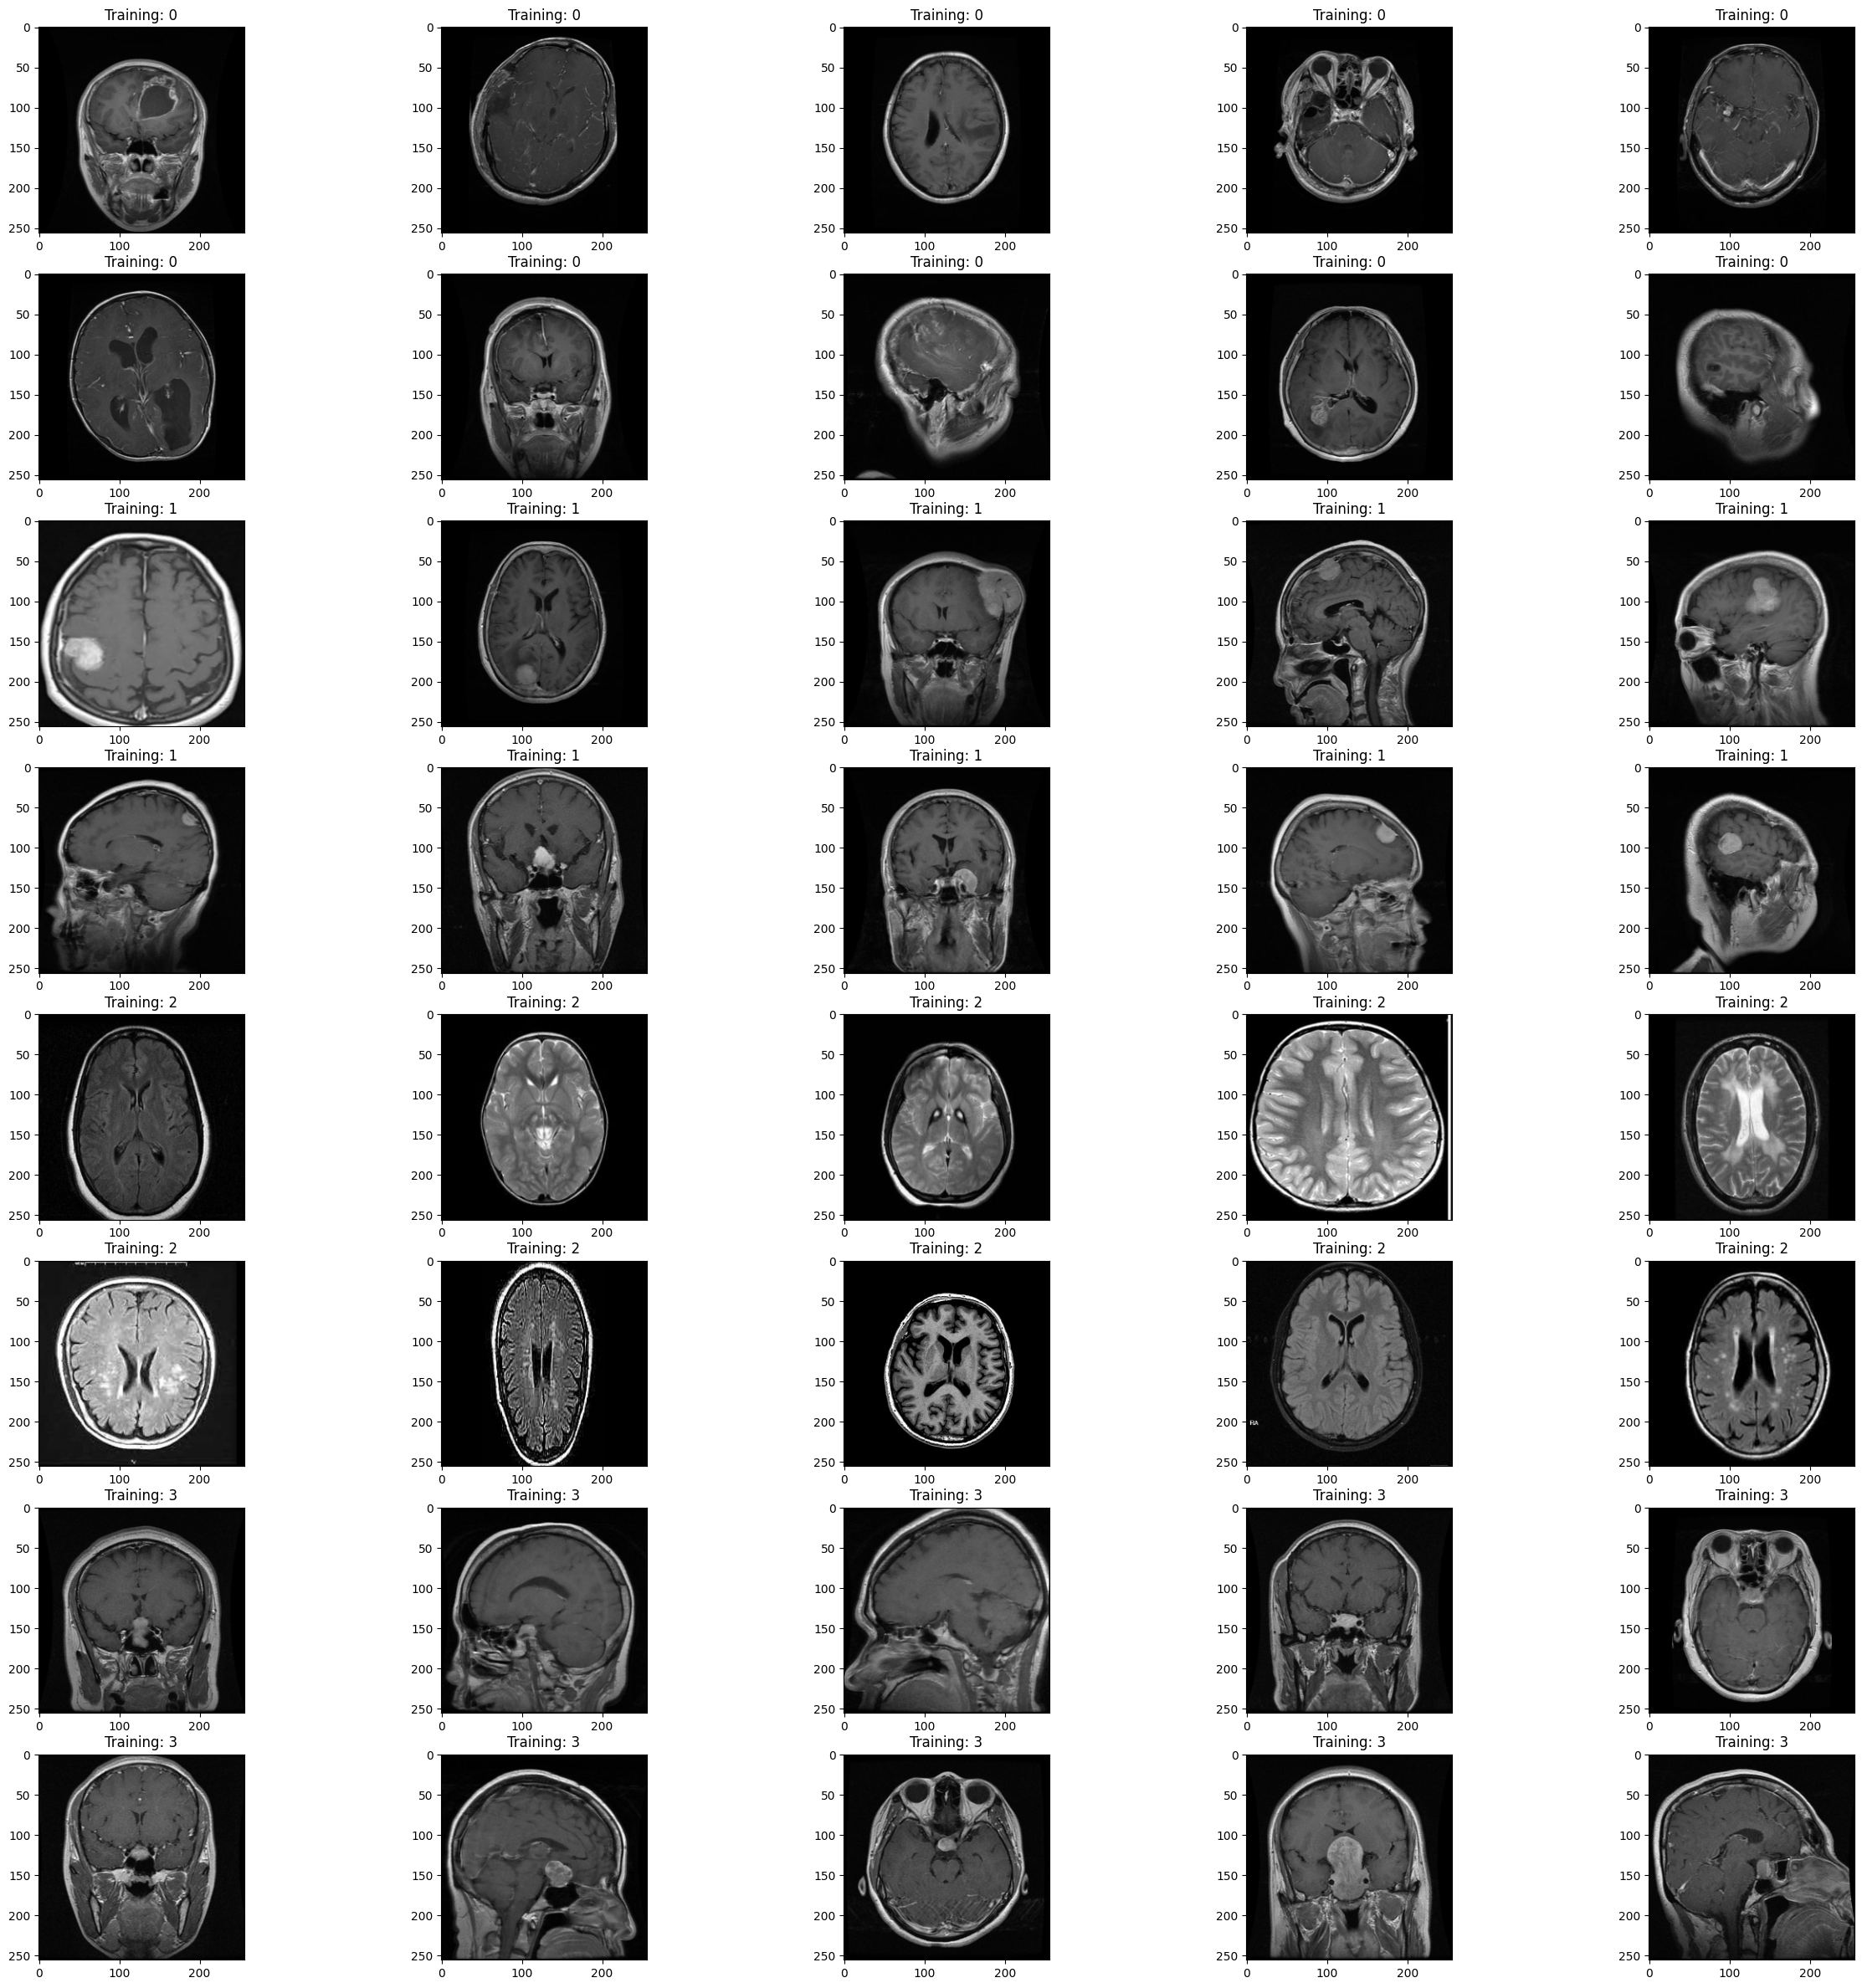

In [17]:
# Display some images from train_paths
plt.figure(figsize=(30, 30))

# Randomly select 10 indices from each set
train_random_indices_0: List[int] = np.random.choice(train_indices_0, 10, replace=False)
train_random_indices_1: List[int] = np.random.choice(train_indices_1, 10, replace=False)
train_random_indices_2: List[int] = np.random.choice(train_indices_2, 10, replace=False)
train_random_indices_3: List[int] = np.random.choice(train_indices_3, 10, replace=False)

train_plot_indices: List[int] = np.concatenate([
    train_random_indices_0, 
    train_random_indices_1, 
    train_random_indices_2, 
    train_random_indices_3,
])

# Ensure indices are unique and within bounds
train_plot_indices = list(set(train_plot_indices))
train_plot_indices.sort()

for index, (image, label) in enumerate(zip(train_paths[train_plot_indices], train_labels[train_plot_indices])):
    plt.subplot(8, 5, index + 1)
    plt.imshow(np.reshape(image, (IMG_SIZE, IMG_SIZE)), cmap=plt.cm.gray)
    plt.title(f'Training: {label}')
    
plt.show()

#### **2.4.2: Identifying MRI Scan Angling**

MRI scans in this Kaggle dataset are all ideally taken from <a href="https://faculty.washington.edu/chudler/slice.html">coronal, sagittal, and horizontal views</a>—in geomertric terms, this means that MRI scans are ideally taken in angles orthogonal to the $xy$, $yz$, or $xz$ planes intersecting a person's face. These angles are standard and seem to largely be what a model we have would be trained on based on the visualization above. However, there is a chance that some of the scans are taken from an <a href="https://www.mr-tip.com/serv1.php?type=db1&dbs=Oblique#:~:text=News%20(%201%20)-,Oblique,axis%20views%20of%20the%20heart.">oblique view</a>, meaning that scans are taken from non-orthogonal angles and showcase a less standard and less clear view of a patient's brain. These scans can likely be the result of a patient flinching and moving before the images are taken. The middle image in the third row of the graph above could maybe be one of these oblique scans for example, because while the scan is clearly an attempt at getting a saggital view of a patient's brain in the MRI scan, the jaw of the patient cannot be clearly defined, suggesting that the patient's head might be twisted in some way where could not capture the jaw as easily as seen in other sagittal scans. 

Ideally in a model, depending on the model we are using, we would consider removing the scans taken from oblique views, because we would not want the training or fine-tuning of our model to be influenced by non-standard angles. While certain models excel in accommodating for variations in angles that pictures are taken, it's generally considered best practice to maintain consistency in the training data. Including a label indicating the scan's direction would be beneficial, allowing us to one-hot-encode this information and feed it as an additional parameter to the model. Possessing such data provides flexibility; we can experiment with including and excluding the type of MRI scans taken in the training process, ensuring we're making informed decisions. It's always more advantageous to have this data and evaluate its relevance, rather than lacking it as a whole.

#### **2.4.3: Honing in on T1 vs. T2 Imaging Discrepency**

MRI's primarily utilize two primary sequences: <a href="https://case.edu/med/neurology/NR/MRI%20Basics.htm">T1-weighted and T2-weighted imaging</a>. These sequences differentiate based on the relaxation times of the tissue being imaged. T1 and T2 relaxation times are measures of how the atomic nuclei within our body's tissues revert to their natural state after being disturbed by a magnetic pulse. T1-weighted images are generated using short TE (Echo Time) and TR (Repetition Time), and the image contrast predominantly hinges on the T1 properties of the tissue. On the flip side, T2-weighted images utilize longer TE and TR times, deriving image contrast mainly from the T2 properties of tissue. A hallmark distinction between these two is how cerebrospinal fluid (CSF) appears: it's **dark in T1-weighted imaging** and **bright in T2-weighted imaging** (assistance in finding T1 and T2 information was also found and corrected through ChatGPT, then we validated it with the source linked above from Case Western).

Observing the MRI scans in the dataset, it's noticeable that no-tumor scans predominantly exhibit a more "white" appearance resembling T2-weighted imaging, meanwhile scans labeled as having tumors lean towards more of a "gray" appearance resembling T1-weighted imaging. The disparity could lead to an unintended bias. This color difference could easily be mis-interpreted as a direct correlation to the presence or absence of tumors. The variation in tone in reality is a product of whether T1 or T2 imaging was employed, instead of being a feature of the tumor presence. This observation raises a critical point: the machine and the method of MRI imaging can influence the output image's appearance. Differentiating between the presence of a tumor should ideally not be contingent on the MRI type. If, for example, all no-tumor scans were predominantly T1 and the tumor scans were T2, our model might be largely basing its decisions on the imaging type rather than the actual presence or nature of the tumor. Such a situation could also indicate that images of distinct categories might have been sourced from specific hospitals or radiologists with a consistent preference for a certain MRI type.

An extra aspect to consider about MRI's of brains with no tumors is that in the Kaggle dataset, these images all are derived from the Br35H dataset, whereas the other MRI scans representing different types of brain tumors all come from different data sources that all ended up compiled together into this Kaggle dataset we are observing now. The authors of this Kaggle dataset did a great job at ensuring that a variety of MRI screening datasets were represented in this sample, but the large T2-weighted imaging bias for predicting lack of tumor based on imaging type may provide us with a false sense of confidence in our models later on when we start our prediction tasks. 

Typically, in a clinical setting, radiologists would provide comprehensive reports accompanying MRI scans. These reports would denote whether T1 or T2 imaging was used, amongst other critical information. However, the Kaggle dataset appears to be stripped of these essential descriptors. Such limitations underline the importance of holistic data for more robust and accurate model training. Without comprehensive metadata, models risk making decisions based on unintended biases rather than genuine features of interest.

To counteract this potential bias, assessing our model's proficiency in distinguishing between glioma, meningioma, and pituitary tumors could provide some insight into its general performance. By focusing on these specific classifications, we can evaluate the model's true distinctive power on MRI scans based on tumors rather than imaging techniques.

#### **2.4.4: Visualizing the Data in the Testing Kaggle Folder**

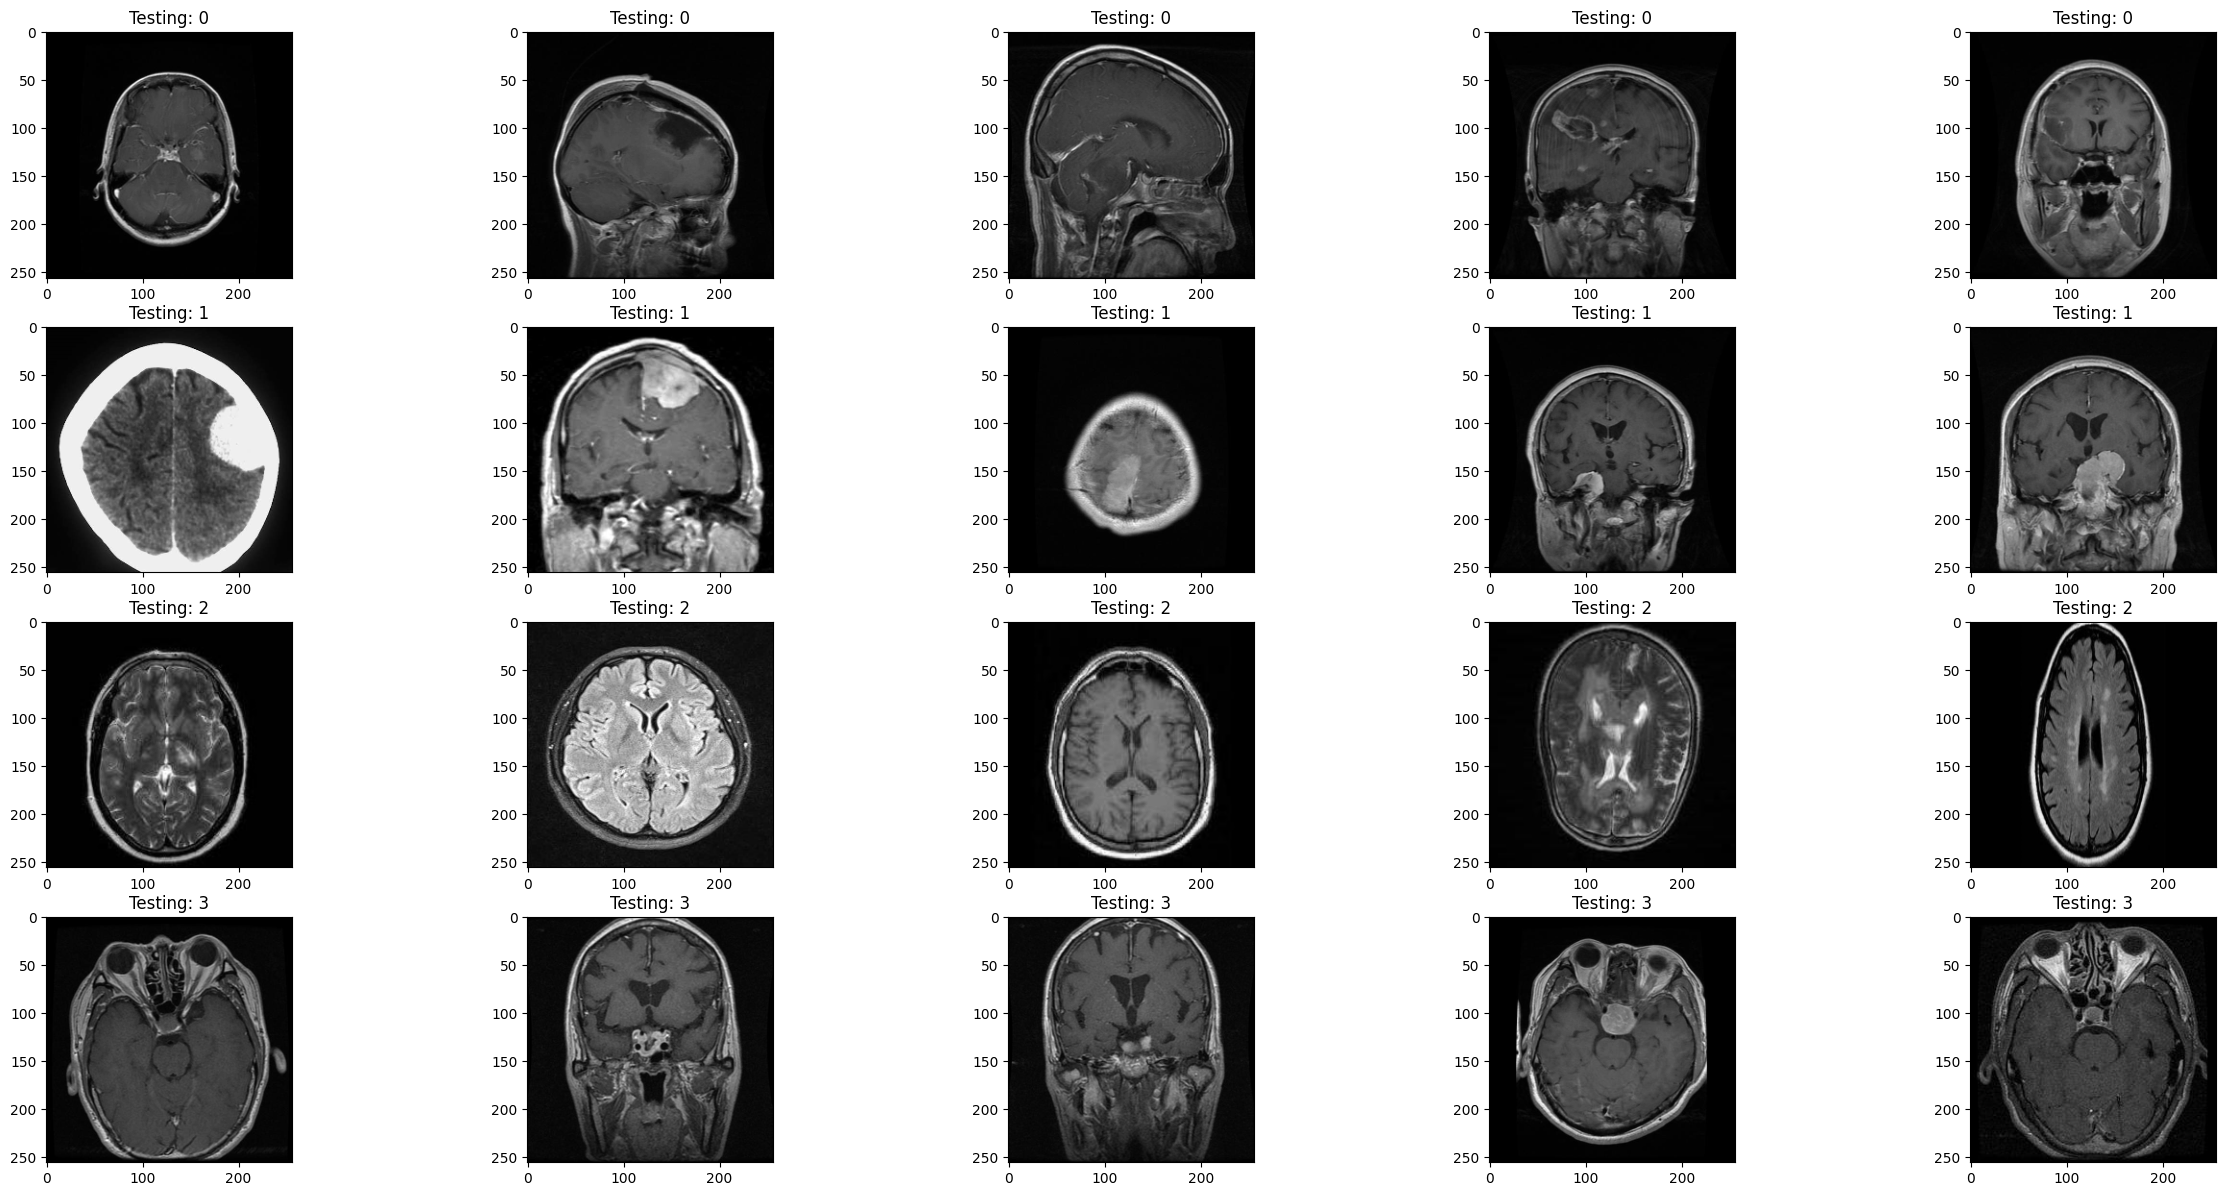

In [18]:
# Display some images from train_paths
plt.figure(figsize=(30, 30))

# Find indices for each label
test_indices_0: List[int] = np.where(np.array(test_labels) == 0)[0]
test_indices_1: List[int] = np.where(np.array(test_labels) == 1)[0]
test_indices_2: List[int] = np.where(np.array(test_labels) == 2)[0]
test_indices_3: List[int] = np.where(np.array(test_labels) == 3)[0]

# Randomly select 5 indices from each set
test_random_indices_0: List[int] = np.random.choice(test_indices_0, 5, replace=False)
test_random_indices_1: List[int] = np.random.choice(test_indices_1, 5, replace=False)
test_random_indices_2: List[int] = np.random.choice(test_indices_2, 5, replace=False)
test_random_indices_3: List[int] = np.random.choice(test_indices_3, 5, replace=False)

test_plot_indices: List[int] = np.concatenate([
    test_random_indices_0, 
    test_random_indices_1, 
    test_random_indices_2, 
    test_random_indices_3,
])

# Ensure indices are unique and within bounds
test_plot_indices = list(set(test_plot_indices))
test_plot_indices.sort()

for index, (image, label) in enumerate(zip(test_paths[test_plot_indices], test_labels[test_plot_indices])):
    plt.subplot(8, 5, index + 1)
    plt.imshow(np.reshape(image, (IMG_SIZE, IMG_SIZE)), cmap=plt.cm.gray)
    plt.title(f'Testing: {label}')
    
plt.show()

#### **2.4.5: Evaluating Kaggle Testing Folder Consistency**

The testing set holds a lot of the same properties as the training set. Most MRI scans here adhere to standard coronal, sagittal, and horizontal views, although potential outliers suggest oblique views exist in the set as well. Furthermore, the trend of T1 and T2 imaging bias is consistent, with a good amount of 'no tumor' images resembling T2-weighted scans and tumor-labeled images looking more like T1-weighted scans. The distribution of MRI scans across labels in the testing set also aligns closely with the training set. While this consistency is reassuring for model evaluation, the potential bias from T1 vs. T2 imaging discrepancy remains a concern. It's crucial to ensure the model's predictions are based on tumor presence or type and not incidental biases or image features.

#### **2.4.6: Listing the Overall Class Distribution for all 4 Classes**

In [19]:
# Insert the total amount of images that appear in the dataset
TOTAL_IMAGES: int = (
    len(train_indices_0) + len(test_indices_0) + 
    len(train_indices_1) + len(test_indices_1) + 
    len(train_indices_2) + len(test_indices_2) + 
    len(train_indices_3) + len(test_indices_3) 
)

# Total number of each individual class
print(f"Number of Glioma images in dataset: {len(train_indices_0) + len(test_indices_0)}")
print(f"Number of Meningioma images in dataset: {len(train_indices_1) + len(test_indices_1)}")
print(f"Number of No Tumor images in dataset: {len(train_indices_2) + len(test_indices_2)}")
print(f"Number of Pituitary images in dataset: {len(train_indices_3) + len(test_indices_3)}\n")

# Total proportion of each individual class
print(f"Proportion of Glioma images in dataset: {100*(len(train_indices_0) + len(test_indices_0)) / TOTAL_IMAGES:.3f}%")
print(f"Proportion of Meningioma images in dataset: {100*(len(train_indices_1) + len(test_indices_1)) / TOTAL_IMAGES:.3f}%")
print(f"Proportion of No Tumor images in dataset: {100*(len(train_indices_2) + len(test_indices_2)) / TOTAL_IMAGES:.3f}%")
print(f"Proportion of Pituitary images in dataset: {100*(len(train_indices_3) + len(test_indices_3)) / TOTAL_IMAGES:.3f}%\n")

# Print total images
print(f"Total Images in Dataset: {TOTAL_IMAGES}", end="")

Number of Glioma images in dataset: 1621
Number of Meningioma images in dataset: 1645
Number of No Tumor images in dataset: 2000
Number of Pituitary images in dataset: 1757

Proportion of Glioma images in dataset: 23.081%
Proportion of Meningioma images in dataset: 23.423%
Proportion of No Tumor images in dataset: 28.478%
Proportion of Pituitary images in dataset: 25.018%

Total Images in Dataset: 7023

The information above showcases the distribution of classes in our overall dataset that we will use before splitting it into a training and testing set. These images WRITE MORE OF A DESCRIPTION HERE ABOUT HOW THE SPLIT IS VERY PROPORTIONAL FOR THE MOST PART WITH A LITTLE BIT OF EXTRA WEIGHTING ON THE NO TUMOR

## **3: Preparation for Modeling and Analysis**

### **3.1: Metrics used to evaluate algorithm's performance**
Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

Our primary goal is to be accurate and reliable in identifying brain tumors. In this case, metrics that emphasize the model's ability to correctly identify positive cases (brains with tumors) are crucial. 

Since we are performing multiclass classification in a medical context, the metrics Precision, Recall, F1 Score, and Area Under the ROC Curve (AUC-ROC) for each class can provide us with a detailed understanding of a model's performance across the various classes. 

#### Multiclass Precision, Recall, and F1 Score
Precision in multiclass settings is calculated separately for each class. It calculates the number of correctly-classified instances within all instances labled as that specific class. Precision is crucial when the cost of false positives is high. In this case, falsely identifying a no-tumor scan as a tumor (false positive) may lead to unnecessary stress and additional testing for the patient.

Recall in multiclass settings is calculated for each class independently. It measures a model's ability to correctly identify all instances of a particular class. Recall measures the number of correctly identified instances within the actual instances of a class. In medical scenarios such as this, it is important to seek high recall, as missing a true tumor case (false negative) has life-threatening consequences. 

The F1 Score provides a single metric that balances both the precision and recall values for each class. It is useful when we need a balance between precision and recall and when the class distribution is uneven, as in our dataset. 

Together, these metrics provide:
- A balanced perspective of the model's performance by considering both false positives and false negatives for our medical application.
- Class-Specific insights into the model's performance by class, which is important given the various types of tumors and the no-tumor classification.
- Imbalanced data handling since some classes are underrepresented, such as some tumor types in this case. Accuracy alone can be misleading in a case such as this one, so these metrics give a nuanced view of the performance instead. 
- Practical relevance by balancing the precision and recall metrics to ensure that the model is accurate and reliable. In this medical context, both missing a tumor (low recall) and falsely diagnosing a tumor (low precision) have significant implications for the patient. It is essential for medical imaging applications to balance both recall and precision in order to maintain accuracy and reliability. 


#### Area Under the Reciever Operating Characteristic Curve (AUC-ROC) for each class
ROC curves can be extended for use in multiclass settings to measure the performance of a model in classifying each class against all others. The AUC-ROC is useful to understand how well a model distinguishes each tumor type from the others. 

AUC-ROC can be extended from binary to multiclass settings using the following approaches:

- One-vs-Rest (OvR) Approach: 
    The AUC-ROC is calculated for each class by treating that class as the positive class and all other classes combined as the negative class. Then the individual AUC-ROC values can be averaged (simple or weighted basted on class representation) to get an overall performance metric.

- One-vs-One (OvO) Approach: 
    The AUC-ROC is computed for every pair of classes. This is more computationally intensive as it requires computing the metric for each class pair.

The multiclass AUC-ROC metric provides a clear, single metric that summarizes the discrimination ability of the model. In this case, this represents insight into how well the model can differentiate between the various types of brain tumors as well as the brains with no tumors.

### **3.2: Method used to divide data into training and testing datasets**
Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

We will use Stratified K-Fold Cross-Validation to divide our dataset into training and testing datasets. This method is suitable for datasets with an imbalanced class distribution, such as ours where the dataset slightly over-represents the no tumor class yet each tumor type still represents about 25% of the total scans. It ensures that each fold of the dataset contains approximately the same percentage of samples of each target class as the complete set. Medical datasets may underrepresent some classes, so this method helps in ensuring that the model is trained and validated on a representative sample of data.

Given the critical nature of accurately diagnosing brain tumors, using Stratified K-Fold Cross-Validation is appropriate. It ensures that each fold is a good representative of the whole dataset, which is crucial for developing a reliable model. This method also mirrors how the algorithm might be used in practice, as it provides a robust estimate of the model's performance across different subsets of data and on new, unseen data. Finally, this is an appropriate choice since we average the results across multiple folds, which can reduce the variance of the model's performance estimate, leading to more confidence in the model's generalizability. 








In [20]:
# Concatenate the original train/test split into one dataset
combined_paths = np.concatenate((train_paths, test_paths), axis=0)
combined_labels = np.concatenate((train_labels, test_labels), axis=0)

# Perform Stratified K-fold Cross Validation
# Using 10 folds (arbitrary right now)
from sklearn.model_selection import StratifiedShuffleSplit

# Shuffle = True because of concatenation
skf = StratifiedShuffleSplit(n_splits = 10, random_state = 42)
for train_index, test_index in skf.split(combined_paths, combined_labels):
    X_train, X_test = combined_paths[train_index], combined_paths[test_index]
    y_train, y_test = combined_labels[train_index], combined_labels[test_index]

# Train and evaluate model using X_train, y_train, X_test, y_test


In [23]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6320, 256, 256) (6320,) (703, 256, 256) (703,)


In [24]:
datagen = ImageDataGenerator(
    rotation_range=10,  # degrees
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Note: When using this with actual MRI data, make sure the augmentation is sensible for your specific case.

In [25]:

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2023-11-26 19:53:11.621544: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 19:53:11.621933: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 19:53:11.622041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 19:53:13.255687: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 19:53:13.255784: I tensorflow/compile

In [ ]:


mlp_model = Sequential([
    Flatten(input_shape=(256, 256, 1)),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
